## Загрузка необходимых библиотек

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from tqdm.auto import trange

## Загрузка данных

In [4]:
%%capture
!wget https://www.dropbox.com/scl/fi/arzso038p5612jcd8avay/rc-f01-12-2022-t01-12-2023.csv

In [5]:
data = pd.read_csv("RC_F01_12_2022_T01_12_2023.csv", delimiter = ";")

In [6]:
data

,nominal,data,curs,cdx
0,1,01.12.2023,"101,248",Швейцарский франк
1,1,30.11.2023,"101,3849",Швейцарский франк
2,1,29.11.2023,"100,6934",Швейцарский франк
3,1,28.11.2023,"100,629",Швейцарский франк
4,1,25.11.2023,"100,4335",Швейцарский франк
...,...,...,...,...
244,1,07.12.2022,"66,6705",Швейцарский франк
245,1,06.12.2022,"66,5506",Швейцарский франк
246,1,03.12.2022,"66,0482",Швейцарский франк
247,1,02.12.2022,"64,7753",Швейцарский франк


In [7]:
data = data.drop(columns = ['nominal', 'cdx'])

In [8]:
data.head(7)

,data,curs
0,01.12.2023,"101,248"
1,30.11.2023,"101,3849"
2,29.11.2023,"100,6934"
3,28.11.2023,"100,629"
4,25.11.2023,"100,4335"
5,24.11.2023,"99,8081"
6,23.11.2023,"99,6888"


In [9]:
data.curs = data.curs.apply(lambda x: x.replace(',', '.'))

In [10]:
data.curs = data.curs.astype(float)

In [11]:
data.head(7)

,data,curs
0,01.12.2023,101.2480
1,30.11.2023,101.3849
2,29.11.2023,100.6934
3,28.11.2023,100.6290
4,25.11.2023,100.4335
5,24.11.2023,99.8081
6,23.11.2023,99.6888


In [12]:
data = data.rename(columns = {'data': 'date', 'curs': 'rate'})

In [13]:
data.date = pd.to_datetime(data.date, format = '%d.%m.%Y')

In [14]:
data.head(7)

,date,rate
0,2023-12-01,101.2480
1,2023-11-30,101.3849
2,2023-11-29,100.6934
3,2023-11-28,100.6290
4,2023-11-25,100.4335
5,2023-11-24,99.8081
6,2023-11-23,99.6888


In [15]:
data = data.sort_values(by = 'date', ignore_index = True)

In [16]:
data

,date,rate
0,2022-12-01,64.0441
1,2022-12-02,64.7753
2,2022-12-03,66.0482
3,2022-12-06,66.5506
4,2022-12-07,66.6705
...,...,...
244,2023-11-25,100.4335
245,2023-11-28,100.6290
246,2023-11-29,100.6934
247,2023-11-30,101.3849


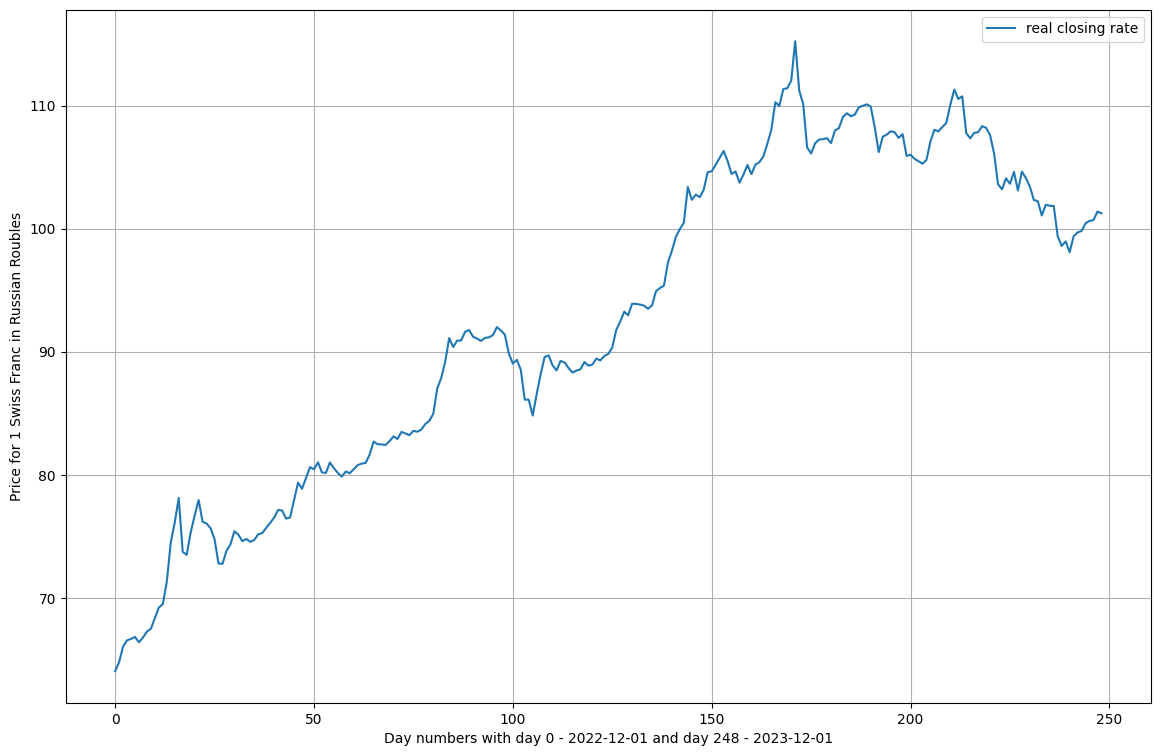

In [22]:
plt.figure(figsize = (14, 9))

plt.plot(data.index, data.rate,
         label='real closing rate')
plt.grid()
plt.legend()
plt.xlabel('Day numbers with day 0 - 2022-12-01 and day 248 - 2023-12-01')
plt.ylabel('Price for 1 Swiss Franc in Russian Roubles');

## Реализация модели Хольта-Уинтерса

In [89]:
def initial_trend(series, slen):
    p_sum = 0.0
    for i in range(slen):
        p_sum += float(series[i + slen] - series[i]) / slen
    return p_sum

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)
    for j in range(n_seasons):
        season_averages.append(sum(series[slen * j:slen * j + slen]) / float(slen))
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma):
    result = []
    res1= []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series) + slen):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            res1.append((smooth + m * trend) + seasonals[i % slen])
            result.append((smooth + m * trend) + seasonals[i % slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha * (val - seasonals[i % slen]) + (1 - alpha) * (smooth + trend)
            trend = beta * (smooth - last_smooth) + (1 - beta) * trend
            seasonals[i % slen] = gamma * (val - smooth) + (1 - gamma) * seasonals[i % slen]
            result.append(smooth + trend + seasonals[i % slen])
    return result, res1

In [79]:
#Гиперпараметры
slen = 14
alpha = 0.5
beta = 0.4
gamma = 0.3
n_preds = slen

series = data.rate[0:len(data.rate) - slen]

In [103]:
result, res1 = triple_exponential_smoothing(series, slen, alpha, beta, gamma)

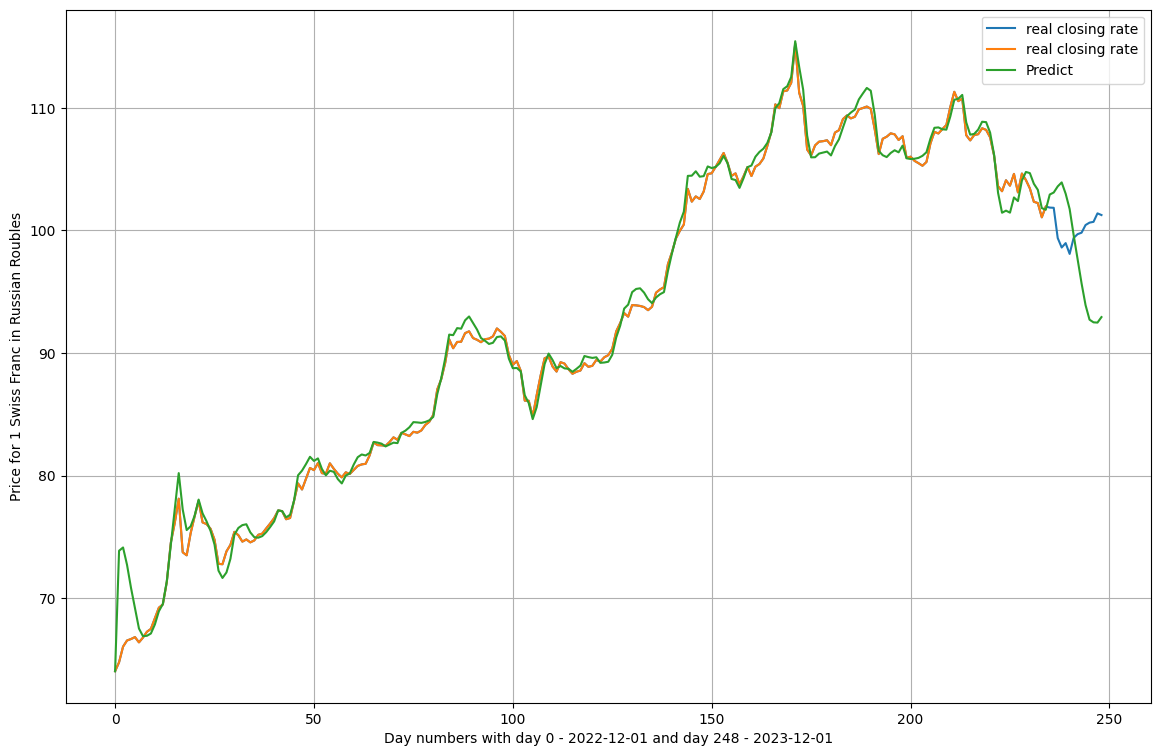

In [81]:
plt.figure(figsize = (14, 9))

plt.plot(data.index, data.rate,
         label='real closing rate')
plt.plot(data.index[0:len(data.rate) - slen], data.rate[0:len(data.rate) - slen],
         label = 'real closing rate')
plt.plot(data.index, result, label='Predict')
plt.grid()
plt.legend()
plt.xlabel('Day numbers with day 0 - 2022-12-01 and day 248 - 2023-12-01')
plt.ylabel('Price for 1 Swiss Franc in Russian Roubles');

Оценка модели

In [82]:
last_season = data[-slen:]['rate'].tolist()

In [83]:
mean_squared_error(res1, last_season)

30.047432899072362

In [84]:
mean_squared_error(data.rate, result)

3.1607209695188847

## Подбор гиперпараметров

In [86]:
#Базовым значением ошибки будет полученное выше значение

error = 30

In [102]:
for i in trange(20):
    for j in range(21):
        for k in range(21):
            for l in range(5, 31):
                _, res1 = triple_exponential_smoothing(series, l, i / 20, j / 20, k / 20)
                last_season = data[-l:]['rate'].tolist()
                temp_error = mean_squared_error(res1, last_season)
                if temp_error < error:
                    error = temp_error
                    al = i / 20
                    be = j / 20
                    ga = k / 20
                    slen_tuned = l

print(f'Best error = {error}. Achieved with parameters:')
print(f'alpha = {al}')
print(f'beta = {be}')
print(f'gamma = {ga}')
print(f'slen = {slen_tuned}')

100%|████████████████████████████| 20/20 [07:44<00:00, 23.22s/it]

Best error = 0.021466091919884894. Achieved with parameters:
alpha = 0.7000000000000001
beta = 0.9
gamma = 0.55


In [105]:
print(f'slen = {slen_tuned}')

slen = 5


Пересоздадим модель с найденными гиперпараметрами

In [106]:
#Гиперпараметры
slen = slen_tuned
alpha = al
beta = be
gamma = ga
n_preds = slen_tuned

series = data.rate[0:len(data.rate) - slen]

In [107]:
result, res1 = triple_exponential_smoothing(series, slen, alpha, beta, gamma)

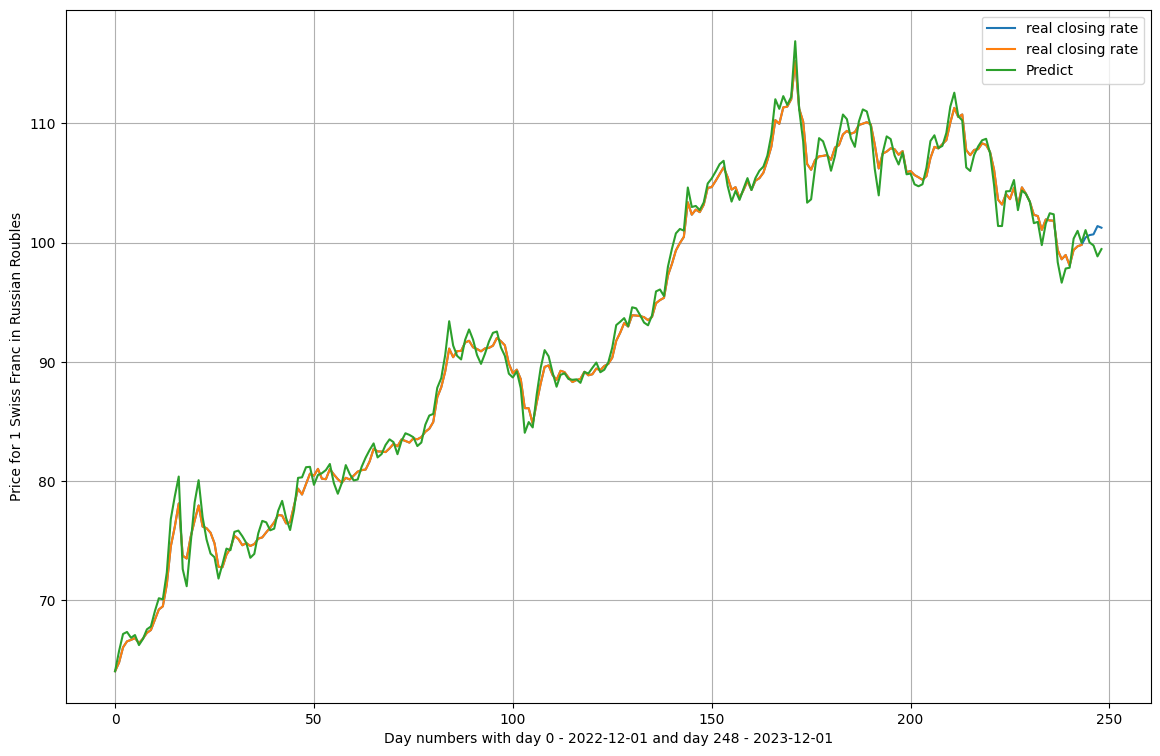

In [108]:
plt.figure(figsize = (14, 9))

plt.plot(data.index, data.rate,
         label='real closing rate')
plt.plot(data.index[0:len(data.rate) - slen], data.rate[0:len(data.rate) - slen],
         label = 'real closing rate')
plt.plot(data.index, result, label='Predict')
plt.grid()
plt.legend()
plt.xlabel('Day numbers with day 0 - 2022-12-01 and day 248 - 2023-12-01')
plt.ylabel('Price for 1 Swiss Franc in Russian Roubles');

Оценка модели

In [109]:
last_season = data[-slen:]['rate'].tolist()

In [110]:
mean_squared_error(res1, last_season)

2.258707687102109

In [111]:
mean_squared_error(data.rate, result)

0.8916011202573668